In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- 1. 环境与参数设置 ---

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 设置 pandas 对齐中文字符
pd.set_option('display.unicode.east_asian_width', True)

# 定义区块名称及其对应的列名
LOCATIONS = {
    '西三旗': 'location_1',
    '清河': 'location_2',
    '西二旗': 'location_3',
    '上地': 'location_4'
}

# --- 2. 数据加载与准备 ---

# 加载数据
try:
    df_esf = pd.read_excel('total_esf.xlsx')
    df_zu = pd.read_excel('total_zu.xlsx')
except FileNotFoundError:
    print("错误：请确保 'total_esf.xlsx' 和 'total_zu.xlsx' 文件在当前目录下。")
    exit()

# 计算单位面积价格
df_esf['price_per_m2'] = df_esf['total'] * 10000 / df_esf['square']
df_zu['rent_per_m2'] = df_zu['rent'] / df_zu['square']

# 将 one-hot 编码的 location 列转换回单一的文本列
location_mapping = {col: name for name, col in LOCATIONS.items()}
df_esf['location'] = df_esf[LOCATIONS.values()].idxmax(axis=1).map(location_mapping)
df_zu['location'] = df_zu[LOCATIONS.values()].idxmax(axis=1).map(location_mapping)
df_zu

,square,rent,location_1,location_2,location_3,location_4,rent_per_m2,location
0,85,6600,0,1,0,0,77.647059,清河
1,12,1700,0,1,0,0,141.666667,清河
2,48,4200,0,1,0,0,87.500000,清河
3,18,2000,0,1,0,0,111.111111,清河
4,12,1800,0,1,0,0,150.000000,清河
...,...,...,...,...,...,...,...,...
3745,120,8800,0,0,0,1,73.333333,上地
3746,46,6300,0,0,0,1,136.956522,上地
3747,148,19000,0,0,0,1,128.378378,上地
3748,114,12000,0,0,0,1,105.263158,上地


In [3]:
df_esf

,square,total,unit,location_1,location_2,location_3,location_4,price_per_m2,location
0,125.54,1265.0,100764,0,1,0,0,100764.696511,清河
1,229.12,1800.0,78561,0,1,0,0,78561.452514,清河
2,233.06,1780.0,76375,0,1,0,0,76375.182356,清河
3,216.93,1498.0,69054,0,1,0,0,69054.533721,清河
4,217.95,2050.0,94058,0,1,0,0,94058.270245,清河
...,...,...,...,...,...,...,...,...,...
4415,99.48,760.0,76398,0,0,0,1,76397.265782,上地
4416,99.33,795.0,80037,0,0,0,1,80036.242827,上地
4417,103.70,950.0,91610,0,0,0,1,91610.414658,上地
4418,66.06,635.0,96125,0,0,0,1,96124.735089,上地


In [7]:
# --- 3. 构建与训练回归模型 ---

# 将 location 视为分类变量
formula_price = 'price_per_m2 ~ square + location'
formula_rent = 'rent_per_m2 ~ square + location'

# 训练模型一：房价模型
model_price = smf.ols(formula_price, data=df_esf).fit()

# 训练模型二：租金模型
model_rent = smf.ols(formula_rent, data=df_zu).fit()

# 回归结果摘要
print("模型一：房价模型 (price_per_m2) 回归结果摘要")
print(model_price.summary())

模型一：房价模型 (price_per_m2) 回归结果摘要
                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     607.8
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:38:23   Log-Likelihood:                -50487.
No. Observations:                4420   AIC:                         1.010e+05
Df Residuals:                    4415   BIC:                         1.010e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept  

In [8]:
print("模型二：租金模型 (rent_per_m2) 回归结果摘要")
print(model_rent.summary())

模型二：租金模型 (rent_per_m2) 回归结果摘要
                            OLS Regression Results                            
Dep. Variable:            rent_per_m2   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.975
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           3.28e-07
Time:                        11:38:25   Log-Likelihood:                -24424.
No. Observations:                3750   AIC:                         4.886e+04
Df Residuals:                    3745   BIC:                         4.889e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept   

In [11]:
# --- 4. 使用模型进行交叉预测并计算租售比 ---

# 为所有数据点（包括二手房和租房数据）生成预测值
# 这样做可以为每条记录都计算一个基于模型的租售比
df_esf['predicted_price_m2'] = model_price.predict(df_esf)
df_esf['predicted_rent_m2'] = model_rent.predict(df_esf)

df_zu['predicted_price_m2'] = model_price.predict(df_zu)
df_zu['predicted_rent_m2'] = model_rent.predict(df_zu)

# 计算模型预测的租售比
df_esf['model_ratio'] = df_esf['predicted_price_m2'] / df_esf['predicted_rent_m2']
df_zu['model_ratio'] = df_zu['predicted_price_m2'] / df_zu['predicted_rent_m2']

# 合并两个数据集的 'location' 和 'model_ratio' 以便进行后续分析
combined_df = pd.concat([
    df_esf[['location', 'model_ratio']],
    df_zu[['location', 'model_ratio']]
])
print(combined_df)

     location  model_ratio
0        清河   710.206711
1        清河   710.227235
2        清河   710.227991
3        清河   710.224883
4        清河   710.225081
...       ...          ...
3745     上地   841.552719
3746     上地   845.162505
3747     上地   840.236960
3748     上地   841.838158
3749     上地   844.464354

[8170 rows x 2 columns]


In [12]:
# 按区块计算模型租售比的中位数
median_ratios_by_block = combined_df.groupby('location')['model_ratio'].median().reset_index()

print("各区块基于模型预测的租售比中位数")
print(median_ratios_by_block)

各区块基于模型预测的租售比中位数
  location  model_ratio
0     上地   842.539409
1     清河   710.200615
2   西三旗   631.301435
3   西二旗   606.558431


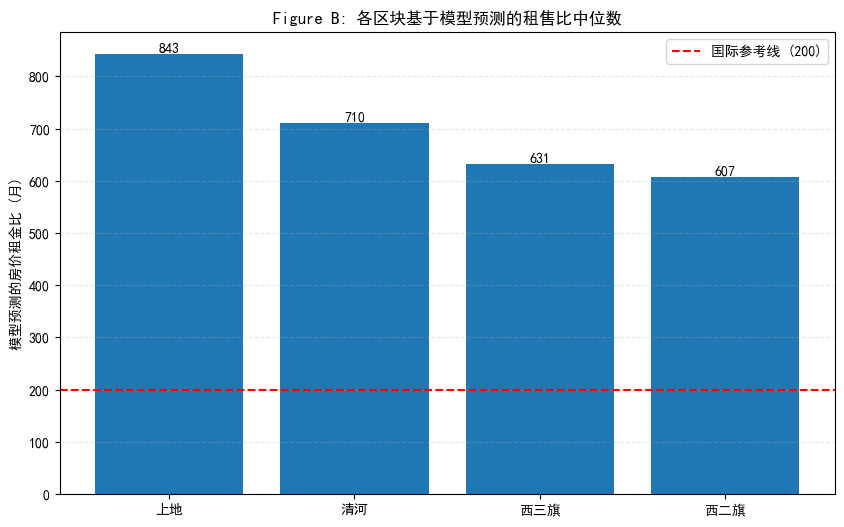

In [17]:
# --- 5. 可视化 (Figure B) ---

plt.figure(figsize=(10, 6))
bars = plt.bar(median_ratios_by_block['location'], median_ratios_by_block['model_ratio'])
plt.axhline(y=200, color='red', linestyle='--', label='国际参考线 (200)')

# 在柱状图顶部显示数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.0f}', va='bottom', ha='center')

plt.ylabel('模型预测的房价租金比 (月)')
plt.title('Figure B: 各区块基于模型预测的租售比中位数')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend() 
plt.savefig('Figure_B_Model_Price-to-Rent_Ratio.png', dpi=300)
plt.show()